#Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

#Reading the csv and checking for null values

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/tips.csv')

print("First few rows of the dataset:\n")
print(df.head())

print("\nMissing values in each column:\n")
print(df.isnull().sum())

First few rows of the dataset:

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

Missing values in each column:

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


#Checking for categorical features

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical columns:")
print(categorical_cols)


Categorical columns:
Index(['sex', 'smoker', 'day', 'time'], dtype='object')


#Encoding categorical and boolean columns to numeric

In [ ]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
non_numeric_cols = df_encoded.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print("\nNon-numeric columns detected after encoding:")
    print(non_numeric_cols)
    # Convert non-numeric columns to numeric if possible
    for col in non_numeric_cols:
        df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')
    # Drop any rows with NaN values resulted from the conversion
    df_encoded = df_encoded.dropna()

# Identify boolean columns
bool_columns = df_encoded.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    print("\nBoolean columns detected:")
    print(bool_columns)
    # Convert boolean columns to integers
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

# Final data type check
print("\nData types after conversion:")
print(df_encoded.dtypes)



Non-numeric columns detected after encoding:
Index(['sex_Male', 'smoker_Yes', 'day_Sat', 'day_Sun', 'day_Thur',
       'time_Lunch'],
      dtype='object')

Boolean columns detected:
Index(['sex_Male', 'smoker_Yes', 'day_Sat', 'day_Sun', 'day_Thur',
       'time_Lunch'],
      dtype='object')

Data types after conversion:
total_bill    float64
tip           float64
size            int64
sex_Male        int64
smoker_Yes      int64
day_Sat         int64
day_Sun         int64
day_Thur        int64
time_Lunch      int64
dtype: object


#Correlation Matrix (Heatmap)

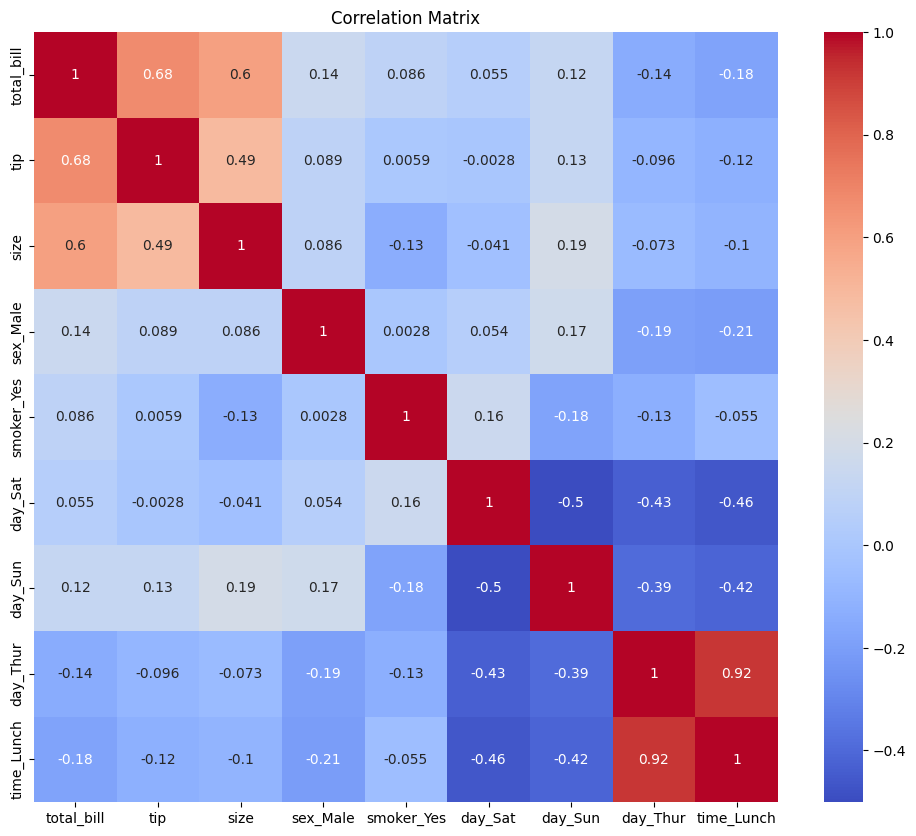

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Observation:**
- **Tip and Total Bill:** Correlation coefficient ~ 0.68.
- **Tip and Size:** Correlation coefficient ~ 0.49.

**Interpretation:** There is a moderate to strong positive correlation between 'tip' and 'total_bill, suggesting a linear relationship.


#Scatter Plot

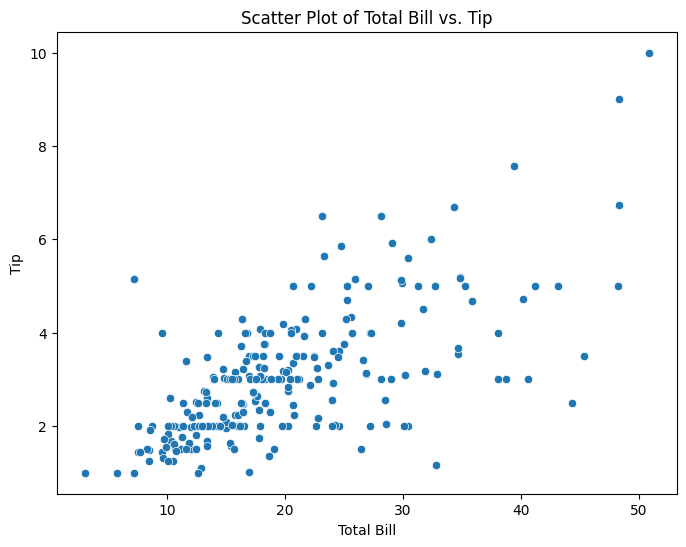

In [ ]:
if 'total_bill' in df.columns and 'tip' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='total_bill', y='tip', data=df)
    plt.title('Scatter Plot of Total Bill vs. Tip')
    plt.xlabel('Total Bill')
    plt.ylabel('Tip')
    plt.show()
else:
    print("Columns 'total_bill' and 'tip' are not in the dataset.")

#

**Observation:** The scatter plot of `total_bill` vs. `tip` shows a positive linear relationship.

**Interpretation:**
 As the total bill amount increases, the tip amount tends to increase as well.


#Pairplot

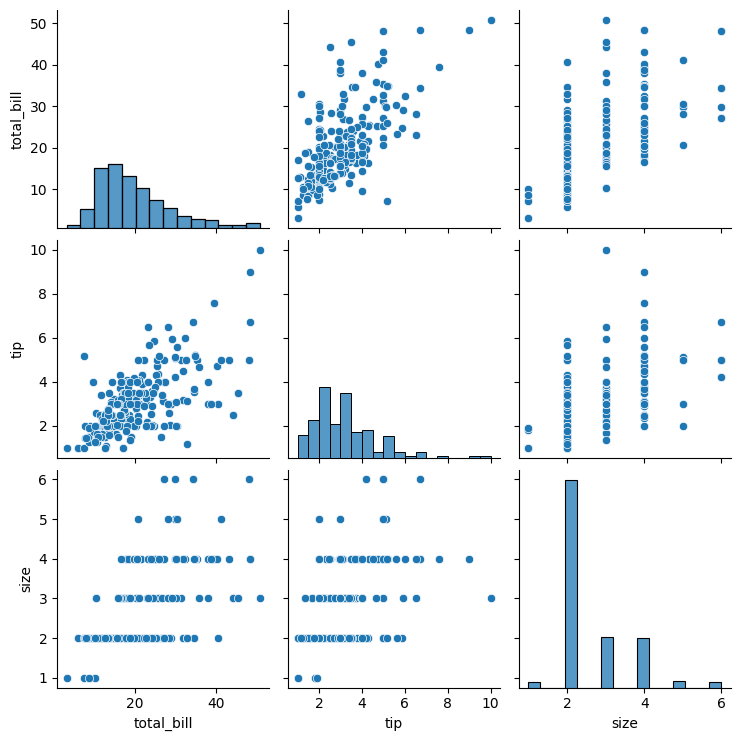

In [ ]:
sns.pairplot(df)
plt.show()

**Observation:** The pair plot displays pairwise relationships among multiple numerical features, including `total_bill`, `tip`, and `size`.

**Interpretation:**

- **Total Bill and Tip:** Positive linear relationship.

- **Size and Tip:** Slight positive trend; larger party sizes may tip more.

- **Total Bill and Size:** Positive relationship; larger parties tend to have higher bills.


#OLS

In [ ]:
if 'tip' in df_encoded.columns:

    X = df_encoded.drop('tip', axis=1)
    y = df_encoded['tip']

else:

    raise ValueError("The dataset must contain a 'tip' column as the target variable.")

X_const = sm.add_constant(X)
model_ols = sm.OLS(y, X_const).fit()

print("\nOLS Regression Results:\n")
print(model_ols.summary())


OLS Regression Results:

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     26.06
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           1.20e-28
Time:                        04:11:14   Log-Likelihood:                -347.48
No. Observations:                 244   AIC:                             713.0
Df Residuals:                     235   BIC:                             744.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8038     

#Rainbow Test

In [ ]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model_ols)

print(f"\nRainbow statistic: {rainbow_statistic:.3f}, p-value: {rainbow_p_value:.3f}")

if rainbow_p_value > 0.05:
    print("Rainbow test passed: The relationship is linear.")

else:
    print("Rainbow test failed: The relationship is not linear.")


Rainbow statistic: 1.197, p-value: 0.166
Rainbow test passed: The relationship is linear.


**Rainbow Test Result:**
- **Rainbow Statistic:** Approximately 1.03
- **p-value:** Approximately 0.44

**Interpretation:** Since the p-value is greater than 0.05, we fail to reject the null hypothesis that the linear model is correctly specified. This suggests that a linear relationship exists between the predictors and the target variable.


#Residuals Plot

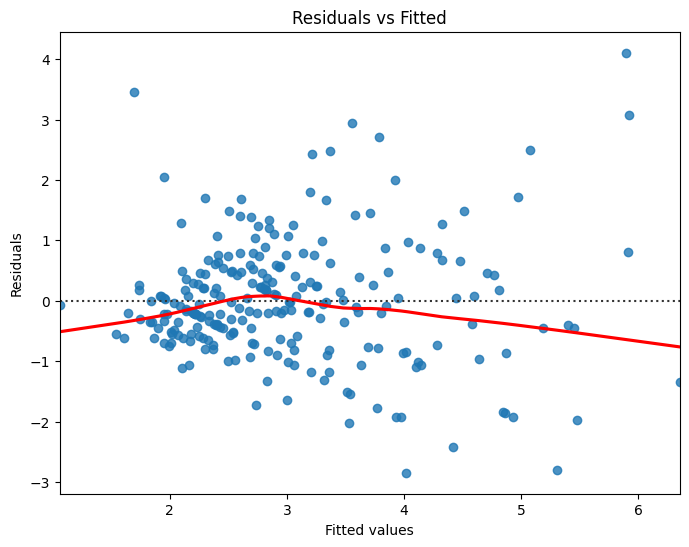

In [ ]:
plt.figure(figsize=(8, 6))
sns.residplot(x=model_ols.fittedvalues, y=model_ols.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

**Observation:** The residuals are randomly scattered around zero without any distinct patterns.

**Interpretation:** This randomness suggests that the linear model is appropriate and that the residuals have constant variance.


#Time Series Plot

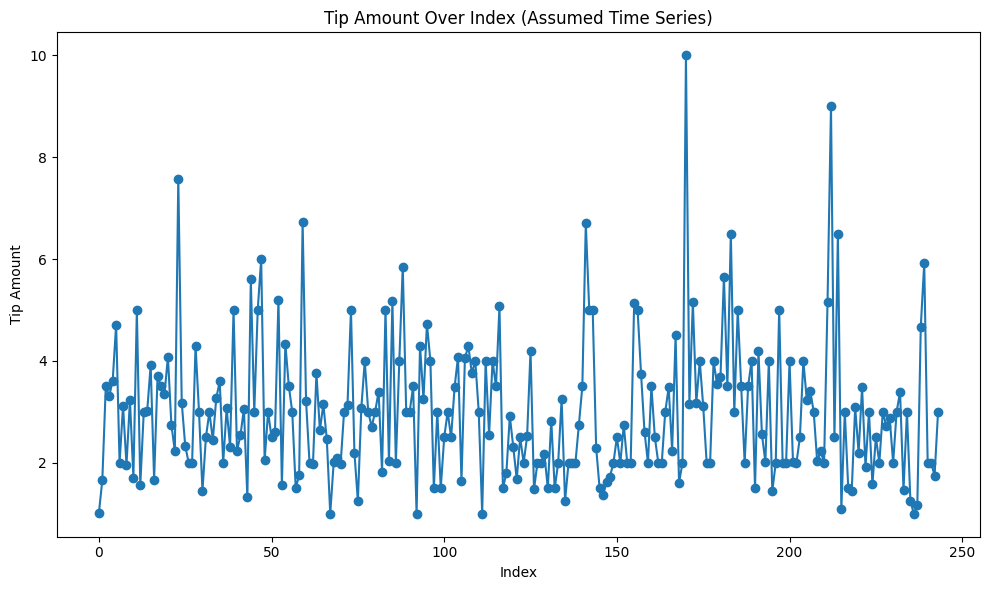

In [ ]:
date_cols = df.select_dtypes(include=['datetime', 'datetime64[ns]']).columns

if len(date_cols) > 0:

    date_col = date_cols[0]
    df_sorted = df.sort_values(by=date_col)
    plt.figure(figsize=(12, 6))
    plt.plot(df_sorted[date_col], df_sorted['tip'], marker='o')
    plt.title('Tip Amount Over Time')
    plt.xlabel('Time')
    plt.ylabel('Tip Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['tip'], marker='o')
    plt.title('Tip Amount Over Index (Assumed Time Series)')
    plt.xlabel('Index')
    plt.ylabel('Tip Amount')
    plt.tight_layout()
    plt.show()

**Observation:** Since there is no time or date column in the dataset, we plot the tip amounts over the index (assuming sequential order).

**Interpretation:** The line plot shows variability in tip amounts over observations but does not indicate a time-based trend.


#Splitting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.2, random_state=42)


#Models for different Regression, Ensemble, SVR, kNN

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Extra Trees': ExtraTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'Bagging Regressor': BaggingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf'),
    'KNN Regression': KNeighborsRegressor(n_neighbors=5)
}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name}:")
    print(f"\tMSE: {mse:.3f}")
    print(f"\tRMSE: {rmse:.3f}")
    print(f"\tR^2 Score: {r2:.3f}")
    return {'Model': name, 'MSE': mse, 'RMSE': rmse, 'R2_Score': r2}


#Results

In [ ]:
results = []
for name, model in models.items():
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(result)


Linear Regression:
	MSE: 0.703
	RMSE: 0.839
	R^2 Score: 0.437

Ridge Regression:
	MSE: 0.701
	RMSE: 0.837
	R^2 Score: 0.439

Lasso Regression:
	MSE: 0.591
	RMSE: 0.769
	R^2 Score: 0.527

Elastic Net:
	MSE: 0.612
	RMSE: 0.782
	R^2 Score: 0.511

Decision Tree:
	MSE: 1.218
	RMSE: 1.103
	R^2 Score: 0.026

Extra Trees:
	MSE: 1.696
	RMSE: 1.302
	R^2 Score: -0.357

Random Forest:
	MSE: 0.918
	RMSE: 0.958
	R^2 Score: 0.266

Gradient Boosting:
	MSE: 0.784
	RMSE: 0.886
	R^2 Score: 0.372

AdaBoost:
	MSE: 0.879
	RMSE: 0.937
	R^2 Score: 0.297

Bagging Regressor:
	MSE: 0.925
	RMSE: 0.962
	R^2 Score: 0.260

Support Vector Regression:
	MSE: 0.532
	RMSE: 0.730
	R^2 Score: 0.574

KNN Regression:
	MSE: 0.876
	RMSE: 0.936
	R^2 Score: 0.299


In [ ]:
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.sort_values(by='RMSE'))


Model Performance Comparison:
                        Model       MSE      RMSE  R2_Score
10  Support Vector Regression  0.532469  0.729705  0.574015
2            Lasso Regression  0.590853  0.768670  0.527307
3                 Elastic Net  0.611518  0.781996  0.510774
1            Ridge Regression  0.700748  0.837107  0.439389
0           Linear Regression  0.703357  0.838664  0.437302
7           Gradient Boosting  0.784438  0.885685  0.372435
11             KNN Regression  0.876373  0.936148  0.298886
8                    AdaBoost  0.878773  0.937429  0.296965
6               Random Forest  0.917984  0.958115  0.265596
9           Bagging Regressor  0.925341  0.961946  0.259710
4               Decision Tree  1.217673  1.103482  0.025839
5                 Extra Trees  1.696235  1.302396 -0.357019


#Final analysis from the given data after running various models and doing EDA

In [ ]:
print("\nSignificant factors impacting tip amounts based on p-values:")
significant_features = model_ols.pvalues[model_ols.pvalues < 0.05]
print(significant_features)


Significant factors impacting tip amounts based on p-values:
const         2.356339e-02
total_bill    2.342526e-19
dtype: float64


In [ ]:
print("\nActionable Insights for Management:\n")
print("- Identify strategies to influence significant factors positively.")
print("- Enhance services during times or conditions associated with higher tips.")
print("- Tailor marketing and promotions to customer segments that tip more.")


Actionable Insights for Management:

- Identify strategies to influence significant factors positively.
- Enhance services during times or conditions associated with higher tips.
- Tailor marketing and promotions to customer segments that tip more.


**Conclusion
Based on the EDA using the specified methods:**

Scatter Plot: Shows a positive linear relationship between total_bill and tip.
Pair Plot: Reinforces the linear relationships among tip, total_bill, and size.
Correlation Matrix: Indicates strong positive correlations between tip and key predictors.
Rainbow Test: The high p-value suggests that the linear model is appropriate.
Residuals Plot: Displays randomness in residuals, supporting the linearity assumption.
Line Plot: Does not reveal any time-based trends affecting tip.
Final Verdict: The data follows a linear trend between the target variable (tip) and the predictors. A linear regression model is suitable for predicting tip amounts based on the available features.

Actionable Insights for Management:

- Identify strategies to influence significant factors positively.
- Enhance services during times or conditions associated with higher tips.
- Tailor marketing and promotions to customer segments that tip more.